## Challenge 4 (8 points)
- Use the data file challenge3.gwf with channels H1:CHALLENGE3 and L1:CHALLENGE3.
- These are real LIGO data from O2, though we've adjusted the time labels and added some simulated signals.
- Any simulated signals have been added to both the H1 and L1 data
- All simulated signals have spin = 0 and m1 = m2, with m1 somewhere in the range 10-50 solar masses
1. Identify as many signals as you can. Watch out! These are real data, and so glitches may be present. Any correct detection is +1 point but any false alarms will count -1 point against your score. For each signal you find, list:
- The merger time
- The SNR
- Your estimate of the component masses
2. Identify as many glitches as you can. Make a spectrogram of each one.

3. For each simulated BBH you found, use bilby to compute a posterior distribution for the mass. You can fix the spin and mass ratio to make this run faster.



Importing the necessary libraries.

In [2]:
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries
from pycbc.waveform import get_td_waveform
from pycbc.types import TimeSeries as pycbc_TimeSeries
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.filter import matched_filter

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


Loading the data.

In [3]:
data = TimeSeries.read("challenge3_2048hz.gwf", channel = "H1:CHALLENGE3")

In [48]:
conditioned=pycbc_TimeSeries(data.value,delta_t=data.dt.value)
dt = conditioned.delta_t
duration = conditioned.duration

In [49]:
psd = conditioned.psd(4)
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)


We are told that all the signals have spin = 0 and mass1 = mass2 and the masses are in the range [10,50]. Therefore, we run a loop over the masses and see how many signals/glitches we can identify.

In [6]:
for m in range(10,50):
    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                            mass1=m,
                            mass2=m,
                            delta_t=dt,
                            f_lower=30)

    hp.resize(len(conditioned))
    template = hp.cyclic_time_shift(hp.start_time)
    snr = matched_filter(template, conditioned,
                        psd=psd, low_frequency_cutoff=20)

    snr = snr.crop(4 + 4, 4)

    peak = abs(snr).numpy().argmax()
    snrp = snr[peak]
    time = snr.sample_times[peak]

    print("We found a signal at {}s with SNR {} with component mass {}".format(time, abs(snrp), m))

We found a signal at 2483.96728515625s with SNR 28.817374431330947 with component mass 10
We found a signal at 2892.7138671875s with SNR 11.99704987821843 with component mass 11
We found a signal at 2892.71240234375s with SNR 13.964868079711986 with component mass 12
We found a signal at 2892.71240234375s with SNR 16.018315381512704 with component mass 13
We found a signal at 1638.158203125s with SNR 16.692617665248918 with component mass 14
We found a signal at 2892.71142578125s with SNR 20.6971170428407 with component mass 15
We found a signal at 1638.15771484375s with SNR 26.681007761328363 with component mass 16
We found a signal at 1638.15673828125s with SNR 37.81340935565652 with component mass 17
We found a signal at 1638.15576171875s with SNR 24.853131745207047 with component mass 18
We found a signal at 2892.7099609375s with SNR 27.606856857164548 with component mass 19
We found a signal at 2892.70947265625s with SNR 32.140962085389916 with component mass 20
We found a signal 

We can see that we have 3 time stamps: 1638s, 2483s and 2892s where signals and glitches are recorded. However, since the signals are identified for each of the whole number values of masses from 10-50, we could have at least 37 glitches. To ascertain whether our matched-filtering has identified a real signal or a glitch, we run the following chi-squared analysis. 

In [ ]:
from pycbc.vetoes import power_chisq

nbins = 26


A chi-squared value of 1 near the merger indicates a good match.

We found a signal at 2483.96728515625s with SNR 28.817374431330947 with component mass 10


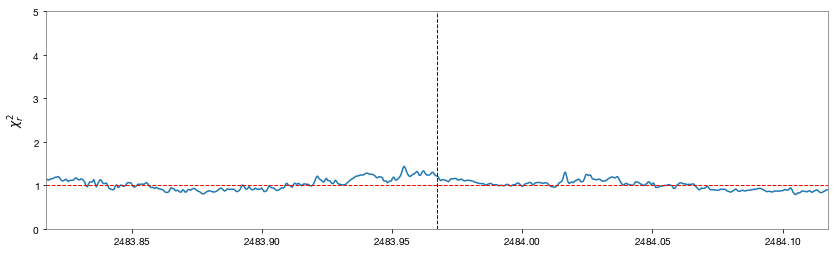

We found a signal at 2892.7138671875s with SNR 11.99704987821843 with component mass 11


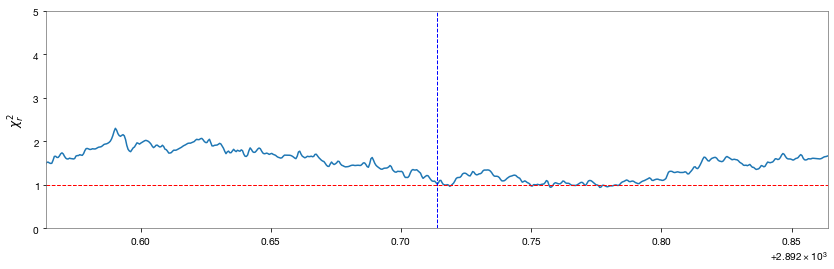

We found a signal at 2892.71240234375s with SNR 13.964868079711986 with component mass 12


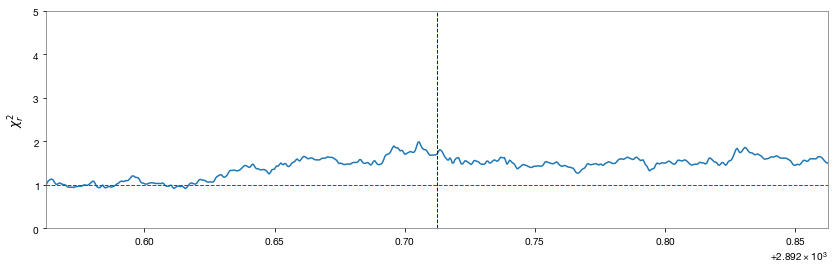

We found a signal at 2892.71240234375s with SNR 16.018315381512704 with component mass 13


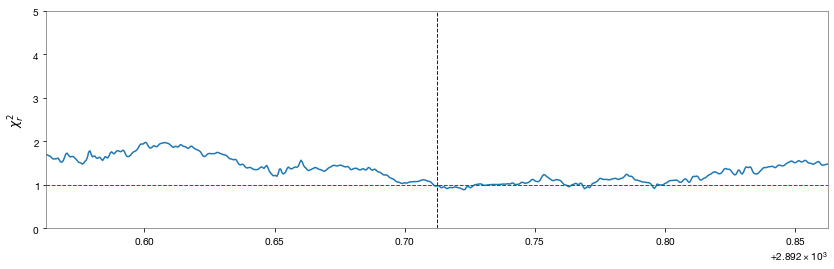

We found a signal at 1638.158203125s with SNR 16.692617665248918 with component mass 14


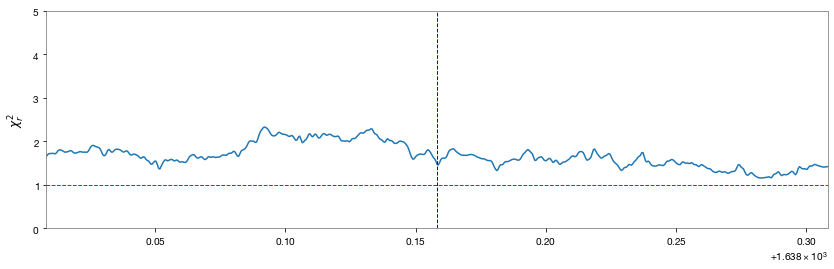

We found a signal at 2892.71142578125s with SNR 20.6971170428407 with component mass 15


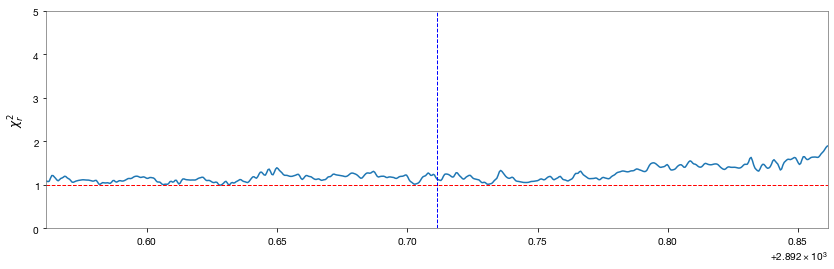

We found a signal at 1638.15771484375s with SNR 26.681007761328363 with component mass 16


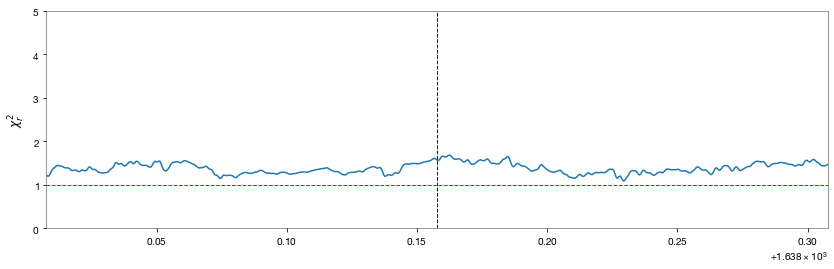

We found a signal at 1638.15673828125s with SNR 37.81340935565652 with component mass 17


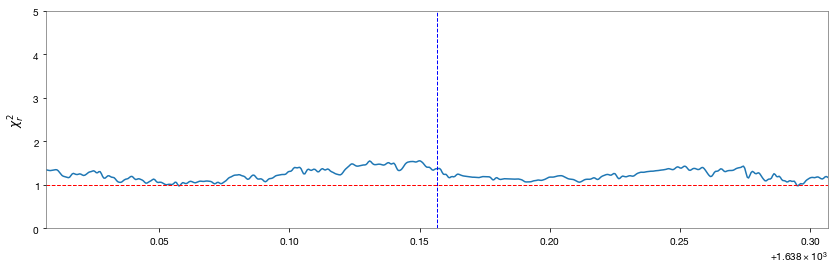

We found a signal at 1638.15576171875s with SNR 24.853131745207047 with component mass 18


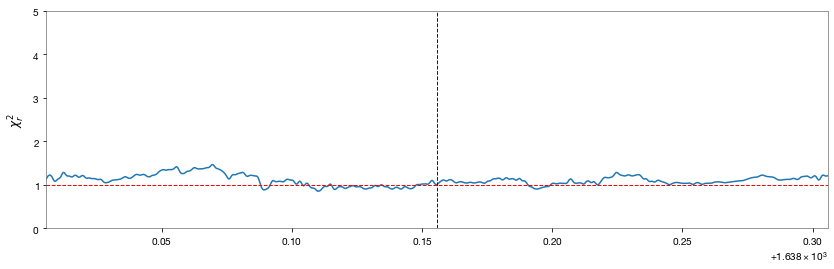

We found a signal at 2892.7099609375s with SNR 27.606856857164548 with component mass 19


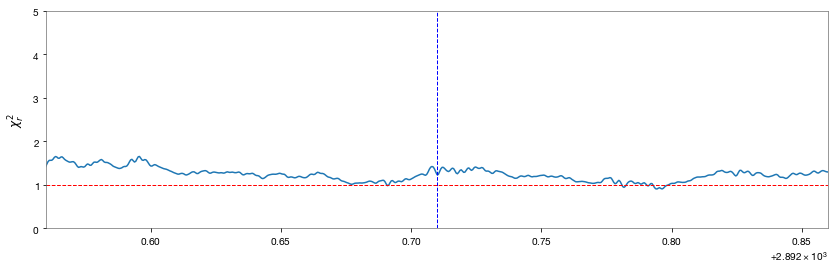

We found a signal at 2892.70947265625s with SNR 32.140962085389916 with component mass 20


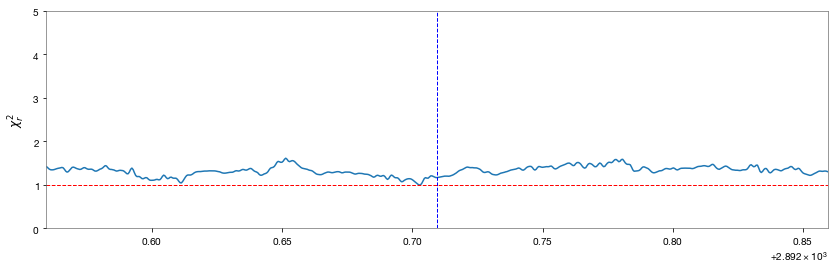

In [65]:
for m in range(10,21):
    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                            mass1=m,
                            mass2=m,
                            delta_t=dt,
                            f_lower=30)

    hp.resize(len(conditioned))
    template = hp.cyclic_time_shift(hp.start_time)
    snr = matched_filter(template, conditioned,
                        psd=psd, low_frequency_cutoff=20)

    snr = snr.crop(4 + 4, 4)

    peak = abs(snr).numpy().argmax()
    snrp = snr[peak]
    time = snr.sample_times[peak]

    print("We found a signal at {}s with SNR {} with component mass {}".format(time, abs(snrp), m))
    chisq = power_chisq(hp, conditioned, nbins, psd, low_frequency_cutoff=20.0)
    chisq = chisq.crop(5, 4)
    dof = nbins * 2 - 2
    chisq /= dof
    plt.figure(figsize=[14, 4])


    plt.plot(chisq.sample_times, chisq, label = f"m = {m}")
        
    plt.grid()
    plt.xlim(time -0.15, time + 0.15)
    plt.ylim(0, 5)
    plt.ylabel('$\chi^2_r$')
    plt.axvline(time, color="blue", linestyle="--", linewidth=1)
    plt.axhline(1, color="red", linestyle="--", linewidth=1)
    plt.show()


- For time = 2484s, the chi-squared value for m = 10 at the time of the merger is very close to 1 indicating a possible merger.
- For time = 1638s, the chi-squared value for m = 18 at the time of the merger are very close to 1 while those for m = 14, 16 and 17 seem to be greater than 1 indicating possible glitches.
- For time = 2893s, the chi-squared value for m = 11 and 13 at the time of the merger are very close to 1 while those for m = 15, 19 and 20 seem to be greater than 1 indicating possible glitches.

The same process can be repeated for the higher mass values to confirm if the high SNR value corresponds to a glitch or a merger signal.